In [1]:
from dotenv import load_dotenv
from googleapiclient.discovery import build
from youtube_transcript_api import YouTubeTranscriptApi
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_core.documents import Document
from langchain_community.tools import DuckDuckGoSearchRun
from typing import TypedDict, Optional
from operator import itemgetter
import re
import os

In [2]:
load_dotenv()

# Initialize APIs
youtube = build('youtube', 'v3', developerKey=os.getenv("YOUTUBE_API_KEY"))
embedder = OpenAIEmbeddings(model="text-embedding-3-small")
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.7)

In [3]:
class SearchResult:
    def __init__(self, search_result):
        self.video_id = search_result['id']['videoId']
        self.title = search_result['snippet']['title']
        self.transcript = self._get_transcript()

    def _get_transcript(self):
        try:
            transcript_list = YouTubeTranscriptApi.get_transcript(self.video_id)
            return " ".join([item['text'] for item in transcript_list])
        except Exception as e:
            print(f"Transcript error for {self.video_id}: {str(e)}")
            return ""

In [4]:
def search_yt(query, max_results=3):
    try:
        request = youtube.search().list(
            part="snippet",
            maxResults=max_results,
            q=query,
            videoCaption='closedCaption',
            type='video',
        )
        return request.execute().get('items', [])
    except Exception as e:
        print(f"YouTube API error: {str(e)}")
        return []

In [5]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)

In [6]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)
def create_faiss_index(items):
    documents = []
    for item in items:
        result = SearchResult(item)
        if not result.transcript:
            continue
            
        full_text = f"Title: {result.title}\nTranscript: {result.transcript}"
        chunks = text_splitter.split_text(full_text)
        
        for chunk in chunks:
            documents.append(Document(
                page_content=chunk,
                metadata={
                    "video_id": result.video_id,
                    "title": result.title
                }
            ))
    
    if not documents:
        print("No valid documents created")
        return None
    
    try:
        return FAISS.from_documents(documents, embedder)
    except Exception as e:
        print(f"FAISS error: {str(e)}")
        return None

In [7]:
# Graph state
class State(TypedDict, total=False):
    topic: str
    author: str
    question: str
    objective_check: bool
    youtube_summary: str
    recent_fact_checks: str
    validate_yt_summary: str
    validate_fact_checks: str
    generate_summary: str

In [8]:
from typing import Optional
from langchain_core.runnables import RunnableLambda

In [165]:
def get_user_input(state: State):
    print("a")
    return {
        "topic": "Rich Dad Poor Dad",
        "author": "Robert Kiyosaki",
        "question": "investment strategy in 2025 ?",
        #"question": "is buying a house a good investment?",
        # "objective_check": None,
        # "youtube_summary": "",
        # "recent_fact_checks": "",
        # "validate_yt_summary": "",
        # "validate_fact_checks": None,
        # "generate_summary": ""
    }

In [166]:
def YouTube_search(state: State):

    print("\n=== Starting YouTube Search ===")
    print(f"YouTube Search... {state['topic']} on  {state['author']}")
    
    # Step 1: Search YouTube
    items = search_yt(f"{state['topic']} {state['author']}")
    if not items:
        print("❌ No search results found")
        return state
    print("✅ Valid search results found")
    
    # Step 2: Create FAISS index
    faiss_index = create_faiss_index(items)
    if not faiss_index:
        print("❌ FAISS index creation failed")
        return state
    print("✅ FAISS index created successfully")
    
    # Step 3: Setup RAG chain
    template = """Analyze and respond as {author} would. Rules:
    1. Use ONLY provided context
    2. Maintain {author}'s style
    3. State "Need information" if context is insufficient
    
    Context: {context}
    Question: {question}
    {author}'s analysis:"""
    
    prompt = ChatPromptTemplate.from_template(template)
    
    rag_chain = (
        {"context": faiss_index.as_retriever(), 
            "question": RunnablePassthrough(),
            "author": lambda _: state["author"]}
        | prompt 
        | llm
        | StrOutputParser()
    )
    
    # Step 4: Generate summary
    state["youtube_summary"] = rag_chain.invoke(state["question"])
    print("✅ YouTube summary generated successfully")
    return state
    

In [167]:
def validate_user_input(state: State):
    validation_prompt = f"""**Relevance Validation Task**
    
    Author: {state['author']}
    Topic: {state['topic']}
    Question: {state['question']}

    **Rules:**
    1. Focus on financial/economic concepts for "Rich Dad Poor Dad" topics
    2. Consider {state['author']}'s known expertise
    3. Allow tangential but related concepts (e.g., assets, investments, cash flow)
    4. Reject completely unrelated topics (e.g., romance, sports, politics)

    **Examples:**
    - Topic: Assets | Question: "Is a house an asset?" → True
    - Topic: Investing | Question: "Best stocks in 2024?" → True  
    - Topic: Cash Flow | Question: "How to find true love?" → False

    **Decision:**
    Respond ONLY with 'True' or 'False'"""

    print(f"Validating: '{state['question']}' against topic: '{state['topic']}'")

    response = llm.invoke(validation_prompt).content.strip().lower()
    is_valid = response == "true"
        
    print(f"Validation result: {is_valid} | Raw response: '{response}'")
    return {"objective_check": is_valid}

In [168]:
import re 

def validate_ytsummary(state: State):
    print(f"\n=== Validating YouTube Summary for '{state['question']}' ===")
        
    feedback_prompt = f"""**Validation Task: Summary Quality Check**

    [Author] {state['author']}
    [Topic] {state['topic']}
    [User Question] {state['question']}

    [Quality Criteria]
    1. Directly answers the specific question asked
    2. Uses {state['author']}'s signature communication style
    3. Contains concrete examples/data from source material
    4. Acknowledges limitations when information is missing

    [Summary to Validate]
    {state['youtube_summary']}

    [Validation Rules]
    - Respond "VALID" if all criteria are met
    - Respond "SEARCH FOR CONTENT: [Topic Area] - [Author] - [Specific Need]" if:
        * Missing key question aspects
        * Contains generic/non-specific information
        * Lacks author-style analysis

    [Examples]
    Good Response: VALID
    Needs Improvement: SEARCH FOR CONTENT: real estate investing - Robert Kiyosaki - 2024 market trends"""

    response = llm.invoke(feedback_prompt).content.strip()
    print(f"Raw validation response: {response}")

    # Process response
    if "VALID" in response.upper():
        state["validate_yt_summary"] = "VALID"
    else:
        # Extract and clean search terms
        search_terms = re.search(r"SEARCH FOR CONTENT: (.+)", response, re.IGNORECASE)
        if search_terms:
            clean_terms = re.sub(r'[^a-zA-Z0-9\s\-,:]', '', search_terms.group(1))
            state["validate_yt_summary"] = f"SEARCH FOR CONTENT: {clean_terms}"
        else:
            # Fallback search template
            state["validate_yt_summary"] = (
                f"SEARCH FOR CONTENT: {state['topic']} - "
                f"{state['author']} - current developments"
            )

    return state


In [209]:
def validate_facts(state: State):
        if not state.get("objective_check", False):
                print("⚠️ Skipping fact checks - failed objective validation")
                state["validate_fact_checks"] = False
                return state

        print("\n=== Validating Factual Accuracy ===")

        validation_prompt = f"""**Fact Check Validation Task**

        Author: {state['author']}
        Topic: {state['topic']}

        [Content to Validate]
        {state['recent_fact_checks'][:2000]}  # Truncate for context limits

        [Validation Criteria]
        1. Contains credible sources (citations, references)
        2. Includes verifiable data/statistics
        3. Aligns with {state['author']}'s known positions
        4. Provides specific examples/evidence

        [Response Format]
        - 'True' if meets all criteria
        - 'False' if any criteria not met

        Answer:"""

        response = llm.invoke(validation_prompt).content.strip().lower()
        is_valid = "true" in response  # Handle variations like "mostly true"

        print(f"Fact check validation result: {is_valid}")
        state["validate_fact_checks"] = is_valid
        return state
   

In [213]:
def route_input(state: State):
    """
    Route the input to the appropriate tool based on the input status"""

    if state["objective_check"] == True:
        print("Accepted")
        return "Accepted"
    elif state["objective_check"] == False:
        print("Rejected")
        return "Rejected"

In [214]:
def route_basedon_Summary(state: dict):
    """
    Route the input to the appropriate tool based on the input status
    """
    validate_yt_summary = state.get("validate_yt_summary", "")

    if validate_yt_summary == "Valid":
        print("Accepted")
        return "Accepted"
    else: "SEARCH" in validate_yt_summary
    print("need more info")
    return "need more info"

In [190]:
def consolidate_summary(state: State):
   
    if not state["objective_check"]:
        state["generate_summary"] = "Question not relevant to the topic"
        return state
        
    # if not state["validate_fact_checks"]:
    #     state["generate_summary"] = "Unable to verify information"
    #     return state

    prompt = f"""Combine these sources in {state['author']}'s style:
    YouTube: {state['youtube_summary']}
    Fact Checks: {state['recent_fact_checks']}
    
    Answer: {state['question']}"""
    
    state["generate_summary"] = llm.invoke(prompt).content
    return state


In [191]:
def fact_checks(state: State):
    search = DuckDuckGoSearchRun()
    search_query = ""

    # Determine search terms
    if "SEARCH:" in state["validate_yt_summary"]:
        # Extract specific search terms
        search_terms = state["validate_yt_summary"].split("SEARCH:")[-1].strip()
        search_query = f"{state['author']} {search_terms}"
        print(f"🔍 Using validation feedback terms: {search_terms}")
    else:
        # Default to author + topic
        search_query = f"{state['author']} {state['topic']}"
        print("🔍 No specific search terms - using author/topic")

    # Execute search
    results = search.invoke(search_query)
    
    # Store results with fallback
    state["recent_fact_checks"] = results[:1000] if results else "No additional information found"
    
    return state

In [210]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph,END
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from typing_extensions import TypedDict

In [ ]:
Graphbuilder = StateGraph(State)
Graphbuilder.add_node("get_user_input", get_user_input)
Graphbuilder.add_node("YouTube_search",YouTube_search)
Graphbuilder.add_node("validate_user_input", validate_user_input)
Graphbuilder.add_node("validate_ytsummary", validate_ytsummary)
Graphbuilder.add_node("fact_checks", fact_checks)
Graphbuilder.add_node("consolidate_summary", consolidate_summary)
Graphbuilder.add_node("validate_facts", validate_facts)


Graphbuilder.add_edge(START, "get_user_input")
Graphbuilder.add_edge("get_user_input", "YouTube_search")
Graphbuilder.add_edge("YouTube_search", "validate_user_input")
Graphbuilder.add_edge("validate_user_input", "validate_ytsummary")
Graphbuilder.add_edge("validate_ytsummary", "fact_checks")
Graphbuilder.add_edge("fact_checks", "validate_facts")
Graphbuilder.add_edge("validate_facts", "consolidate_summary")
Graphbuilder.add_edge("consolidate_summary", END)


Graphbuilder.add_conditional_edges(
    "validate_user_input",
    route_input,
    {
        "Accepted": "fact_checks",
        "Rejected": "consolidate_summary"
    }
)


Graphbuilder.add_conditional_edges(
    "validate_ytsummary",
    route_basedon_Summary,
    {
        "Accepted": "consolidate_summary",
        "need more info": "fact_checks"
    }
)

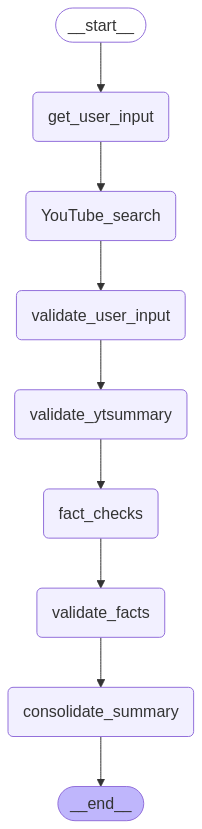

In [212]:
workflow = Graphbuilder.compile()
from IPython.display import Image, display
display(Image(workflow.get_graph().draw_mermaid_png()))

In [208]:
def get_user_input(state: State):
    print("b")
    return {
        "topic": "Rich Dad Poor Dad",
        "author": "Robert Kiyosaki",
        "question": "Can we invest in  Crypto ?"
    }

In [207]:
workflow = Graphbuilder.compile()
state = get_user_input({})
final_State = workflow.invoke(state)
print("Final State: ", final_State)


b
b

=== Starting YouTube Search ===
YouTube Search... Rich Dad Poor Dad on  Robert Kiyosaki
✅ Valid search results found
✅ FAISS index created successfully
✅ YouTube summary generated successfully
Validating: 'Can we invest in  Crypto ?' against topic: 'Rich Dad Poor Dad'
Validation result: True | Raw response: 'true'

=== Validating YouTube Summary for 'Can we invest in  Crypto ?' ===
Raw validation response: SEARCH FOR CONTENT: investing in cryptocurrency - Robert Kiyosaki - specific strategies
🔍 No specific search terms - using author/topic
Final State:  {'topic': 'Rich Dad Poor Dad', 'author': 'Robert Kiyosaki', 'question': 'Can we invest in  Crypto ?', 'objective_check': True, 'youtube_summary': 'Need information', 'recent_fact_checks': 'Rich Dad Poor Dad is a series of 13 books by Robert T. Kiyosaki. The first book published in the series is Rich Dad, Poor Dad in 1997. Here is a complete list of Rich Dad Poor Dad books in order. Robert Kiyosaki, the best-selling author of Rich D